In [ ]:
pip install numpy opencv-python


In [ ]:
#Part A (Task 1)
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the monitor image
monitor_img = cv2.imread('/kaggle/input/part-a/monitor.jpg')

# Convert the image to HSV color space
hsv_img = cv2.cvtColor(monitor_img, cv2.COLOR_BGR2HSV)

# Define the HSV range for detecting red color
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Create a mask for the red color
mask1 = cv2.inRange(hsv_img, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Find contours in the red mask
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to detect the four red corners
corner_points = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 50:  # Threshold area to filter noise; adjust if needed
        # Compute the center of the contour and add it as a corner point
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            corner_points.append([cX, cY])

# Ensure we have exactly four points before proceeding
if len(corner_points) == 4:
    # Convert to a numpy array for easier manipulation
    corner_points = np.array(corner_points)

    # Sort points based on their y-coordinates (top vs. bottom)
    sorted_points = corner_points[np.argsort(corner_points[:, 1])]

    # Split into top and bottom points
    top_points = sorted_points[:2]
    bottom_points = sorted_points[2:]

    # Further sort top points by x-coordinate to get top-left and top-right
    top_left, top_right = top_points[np.argsort(top_points[:, 0])]
    # Sort bottom points to get bottom-left and bottom-right
    bottom_left, bottom_right = bottom_points[np.argsort(bottom_points[:, 0])]

    # Create ordered points
    ordered_corners = np.array([top_left, top_right, bottom_right, bottom_left])

    # Draw the rectangle defined by the four ordered corner points
    monitor_img_with_rectangle = monitor_img.copy()
    cv2.polylines(monitor_img_with_rectangle, [ordered_corners.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=3)

    # Display the monitor image with the rectangle
    plt.figure(figsize=(10, 7))
    plt.imshow(cv2.cvtColor(monitor_img_with_rectangle, cv2.COLOR_BGR2RGB))
    plt.title("Monitor with Bounding Rectangle")
    plt.axis('off')
    plt.show()

    # Load the Rick and Morty image
    rick_morty_img = cv2.imread('/kaggle/input/part-a/rick_and_morty.jpg')

    # Define the points on the Rick and Morty image
    rick_morty_points = np.array([
        [0, 0],
        [rick_morty_img.shape[1] - 1, 0],
        [rick_morty_img.shape[1] - 1, rick_morty_img.shape[0] - 1],
        [0, rick_morty_img.shape[0] - 1]
    ], dtype=np.float32)

    # Convert corner points to float32
    monitor_points = ordered_corners.astype(np.float32)

    # Compute the homography matrix
    H = cv2.getPerspectiveTransform(rick_morty_points, monitor_points)

    # Warp the Rick and Morty image to fit within the detected corners on the monitor
    warped_img = cv2.warpPerspective(rick_morty_img, H, (monitor_img.shape[1], monitor_img.shape[0]))

    # Create a mask for blending the warped image with the monitor image
    mask = np.zeros_like(monitor_img, dtype=np.uint8)
    cv2.fillConvexPoly(mask, monitor_points.astype(int), (255, 255, 255))

    # Blend the warped image into the monitor image
    monitor_img_with_projection = cv2.bitwise_and(monitor_img, cv2.bitwise_not(mask))
    monitor_img_with_projection = cv2.bitwise_or(monitor_img_with_projection, warped_img)

    # Display the final output
    plt.figure(figsize=(10, 7))
    plt.imshow(cv2.cvtColor(monitor_img_with_projection, cv2.COLOR_BGR2RGB))
    plt.title("Monitor with Image Inserted")
    plt.axis('off')
    plt.show()
else:
    print("Could not detect exactly 4 red corner points. Adjust the thresholds or check the input image.")

In [ ]:
# RUN THIS CELL FOR IMPORTING SUPERGLUE ALGORITHM

!git clone https://github.com/magicleap/SuperGluePretrainedNetwork
%cd SuperGluePretrainedNetwork

# Install necessary dependencies
!pip install torch torchvision matplotlib scipy opencv-python
!pip install opencv-contrib-python

In [ ]:
# DOWNLOAD PRETRAINED WEIGHTS
!wget https://storage.googleapis.com/magicleap/SuperGluePretrainedNetwork/models/superpoint_v1.pth
!wget https://storage.googleapis.com/magicleap/SuperGluePretrainedNetwork/models/superglue_outdoor.pth


In [ ]:
import cv2
import numpy as np
import torch
from models.matching import Matching
from models.utils import frame2tensor
import os

# Initialize SuperGlue model
superglue_model = Matching({
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024,
        'weights': '/kaggle/working/SuperGluePretrainedNetwork/models/weights/superpoint_v1.pth'
    },
    'superglue': {
        'weights': 'outdoor'
    }
}).eval().cuda()

# Load Rick and Morty image in grayscale
rick_morty_img = cv2.imread('/kaggle/input/part-a/rick_and_morty.jpg')
rick_morty_img_gray = cv2.cvtColor(rick_morty_img, cv2.COLOR_BGR2GRAY)
rick_morty_img_height, rick_morty_img_width = rick_morty_img_gray.shape[:2]

# Load the video
video_path = '/kaggle/input/part-a/monitor_video1.mp4'
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video path
output_video_path = '/kaggle/working/Pic_on_Video.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Directory to save frames
frames_dir = '/kaggle/working/frames_with_monitor'
os.makedirs(frames_dir, exist_ok=True)

# Initial monitor corners
monitor_corners = np.array([[205, 40], [552, 50], [545, 248], [208, 244]], dtype=np.float32)

# Thresholds for edge detection
low_threshold = 50
high_threshold = 150
previous_frame_gray = None
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current video frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if previous_frame_gray is None:
        previous_frame_gray = frame_gray
        continue

    # Detect edges for better keypoint matching
    edges = cv2.Canny(frame_gray, low_threshold, high_threshold)
    input_current_frame = frame2tensor(frame_gray, torch.device('cuda'))
    input_previous_frame = frame2tensor(previous_frame_gray, torch.device('cuda'))

    # Use the previous frame and the current frame for matching
    pred = superglue_model({'image0': input_previous_frame, 'image1': input_current_frame})

    keypoints_current = pred['keypoints1'][0].cpu().detach().numpy()
    keypoints_previous = pred['keypoints0'][0].cpu().detach().numpy()
    matches = pred['matches1'][0].cpu().detach().numpy()  # matches from the current to previous frame

    valid_matches = matches > -1
    matched_kp_current = keypoints_current[valid_matches]
    matched_kp_previous = keypoints_previous[matches[valid_matches]]

    # Adjust matched keypoints based on distance to previous keypoints (assign high weightage)
    if len(matched_kp_current) >= 6 and len(matched_kp_previous) >= 6:
        # Implementing weightage by focusing on closer points
        weights = np.exp(-np.linalg.norm(matched_kp_previous - matched_kp_current, axis=1))  # Weight based on distance
        weights /= np.sum(weights)  # Normalize weights
        
        # Using RANSAC for homography
        H, mask = cv2.findHomography(matched_kp_previous, matched_kp_current, cv2.RANSAC, ransacReprojThreshold=5.0)

        if H is not None:
            # Transform the monitor corners using the homography
            new_monitor_corners = cv2.perspectiveTransform(monitor_corners.reshape(-1, 1, 2), H)
#             print(new_monitor_corners)
        else:
            new_monitor_corners = monitor_corners  # Use the initial corners if homography fails
            print("none found")
    else:
        print("><4")
        new_monitor_corners = monitor_corners  # If homography cannot be calculated, use the initial corners

    # Define source points as corners of the Rick and Morty image
    src_pts = np.float32([[0, 0], [rick_morty_img_width, 0], [rick_morty_img_width, rick_morty_img_height], [0, rick_morty_img_height]]).reshape(-1, 1, 2)
    
    # Calculate the new perspective transform using the corners of the monitor
    if H is not None:
        H_image = cv2.getPerspectiveTransform(src_pts, new_monitor_corners)
        
        # Warp the Rick and Morty image to fit exactly within the monitor corners
        warped_image = cv2.warpPerspective(rick_morty_img, H_image, (frame_width, frame_height))

        # Create a mask to confine the warped image to the rectangle defined by new_monitor_corners
        mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
        cv2.fillConvexPoly(mask, new_monitor_corners.astype(int), (255))

        # Apply the mask to the warped image and the current frame
        masked_warped_image = cv2.bitwise_and(warped_image, warped_image, mask=mask)
        masked_frame = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(mask))

        # Combine the current frame with the masked warped image
        frame = cv2.add(masked_frame, masked_warped_image)

    # Draw rectangle around the dynamically updated monitor corners
    new_monitor_corners_int = new_monitor_corners.astype(np.int32)  # Convert to int32
    cv2.polylines(frame, [new_monitor_corners_int.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the frame with rectangle drawn
    frame_output_path = os.path.join(frames_dir, f"frame_{frame_count:04d}.png")
    cv2.imwrite(frame_output_path, frame)

    # Write the modified frame to the output video
    out.write(frame)
    previous_frame_gray = frame_gray.copy()
    frame_count += 1

cap.release()
out.release()
print(f"Video saved to: {output_video_path}")
print(f"Frames saved to: {frames_dir}")


In [ ]:
#BONUS TASK
import cv2
import numpy as np
import torch
from models.matching import Matching
from models.utils import frame2tensor
import os

# Initialize SuperGlue model
superglue_model = Matching({
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024,
        'weights': '/kaggle/working/SuperGluePretrainedNetwork/models/weights/superpoint_v1.pth'
    },
    'superglue': {
        'weights': 'outdoor'
    }
}).eval().cuda()

# Load Rick and Morty image in grayscale
rick_morty_img = cv2.imread('/kaggle/input/part-a/rick_and_morty.jpg')
rick_morty_img_gray = cv2.cvtColor(rick_morty_img, cv2.COLOR_BGR2GRAY)
rick_morty_img_height, rick_morty_img_width = rick_morty_img_gray.shape[:2]

# Load the video
video_path = '/kaggle/input/part-a/monitor_video2.mp4'
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video path
output_video_path = '/kaggle/working/BonusVideo.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Directory to save frames
frames_dir = '/kaggle/working/frames_with_monitor'
os.makedirs(frames_dir, exist_ok=True)

# Initial monitor corners (these will be updated each frame)
monitor_corners = np.array([[200, 50], [500, 50], [540, 240], [220, 240]], dtype=np.float32)

low_threshold = 50
high_threshold = 150
previous_frame_gray = None
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert current video frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if previous_frame_gray is None:
        previous_frame_gray = frame_gray
        continue

    edges = cv2.Canny(frame_gray, low_threshold, high_threshold)
    input_frame = frame2tensor(frame_gray, torch.device('cuda'))
    input_rick_morty = frame2tensor(rick_morty_img_gray, torch.device('cuda'))

    pred = superglue_model({'image0': input_frame, 'image1': input_rick_morty})

    keypoints_frame = pred['keypoints0'][0].cpu().detach().numpy()
    keypoints_image = pred['keypoints1'][0].cpu().detach().numpy()
    matches = pred['matches0'][0].cpu().detach().numpy()

    valid_matches = matches > -1
    matched_kp_frame = keypoints_frame[valid_matches]
    matched_kp_image = keypoints_image[matches[valid_matches]]

    if len(matched_kp_frame) >= 6 and len(matched_kp_image) >= 6:
        H, mask = cv2.findHomography(matched_kp_image, matched_kp_frame, cv2.RANSAC)
        
        if H is not None:  # Ensure H is valid
            # Update monitor corners based on the new homography matrix
            new_monitor_corners = cv2.perspectiveTransform(monitor_corners.reshape(-1, 1, 2), H)
        else:
            new_monitor_corners = monitor_corners  # Use the initial corners if homography fails
    else:
        new_monitor_corners = monitor_corners  # If homography cannot be calculated, use the initial corners

    if H is not None:
        # Define source points as corners of the Rick and Morty image
        src_pts = np.float32([[0, 0], [rick_morty_img_width, 0], [rick_morty_img_width, rick_morty_img_height], [0, rick_morty_img_height]]).reshape(-1, 1, 2)
        
        # Calculate the new perspective transform using the corners of the monitor
        H = cv2.getPerspectiveTransform(src_pts, new_monitor_corners)
        
        # Warp the Rick and Morty image to fit exactly within the monitor corners
        warped_image = cv2.warpPerspective(rick_morty_img, H, (frame_width, frame_height))

        # Create a mask to confine the warped image to the rectangle defined by new_monitor_corners
        mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
        cv2.fillConvexPoly(mask, new_monitor_corners.astype(int), (255))

        # Apply the mask to the warped image and the current frame
        masked_warped_image = cv2.bitwise_and(warped_image, warped_image, mask=mask)
        masked_frame = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(mask))

        # Combine the current frame with the masked warped image
        frame = cv2.add(masked_frame, masked_warped_image)

    # Ensure new_monitor_corners is of the correct type and shape for drawing
    new_monitor_corners_int = new_monitor_corners.astype(np.int32)  # Convert to int32

    # Draw rectangle around the dynamically updated monitor corners
    cv2.polylines(frame, [new_monitor_corners_int.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the frame with rectangle drawn
    frame_output_path = os.path.join(frames_dir, f"frame_{frame_count:04d}.png")
    cv2.imwrite(frame_output_path, frame)

    # Write the modified frame to the output video
    out.write(frame)
    previous_frame_gray = frame_gray.copy()
    frame_count += 1

cap.release()
out.release()
print(f"Video saved to: {output_video_path}")
print(f"Frames saved to: {frames_dir}")




In [ ]:
import cv2
import numpy as np
import torch
from models.matching import Matching
from models.utils import frame2tensor
import os

# Initialize SuperGlue model
superglue_model = Matching({
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024,
        'weights': '/kaggle/working/SuperGluePretrainedNetwork/models/weights/superpoint_v1.pth'
    },
    'superglue': {
        'weights': 'outdoor'
    }
}).eval().cuda()

# Load video to project
project_video_path = '/kaggle/input/part-a-3/RM_clip.mp4'  # Path to the video to project onto the monitor
project_cap = cv2.VideoCapture(project_video_path)
project_fps = int(project_cap.get(cv2.CAP_PROP_FPS))
project_frame_width = int(project_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
project_frame_height = int(project_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Load the main video
video_path = '/kaggle/input/part-a/monitor_video1.mp4'
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video path
output_video_path = '/kaggle/working/Video_on_Video.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Directory to save frames
frames_dir = '/kaggle/working/frames_with_monitor'
os.makedirs(frames_dir, exist_ok=True)

# Initial monitor corners (these will be updated each frame)
monitor_corners = np.array([[205, 40],[552, 50],[545, 248],[208, 244]], dtype=np.float32)

low_threshold = 50
high_threshold = 150
previous_frame_gray = None
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    ret_project, project_frame = project_cap.read()

    if not ret or not ret_project:
        break

    # Resize the project frame to monitor size if needed
    project_frame_gray = cv2.cvtColor(project_frame, cv2.COLOR_BGR2GRAY)
    project_height, project_width = project_frame_gray.shape[:2]

    # Convert current video frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if previous_frame_gray is None:
        previous_frame_gray = frame_gray
        continue

    edges = cv2.Canny(frame_gray, low_threshold, high_threshold)
    input_frame = frame2tensor(frame_gray, torch.device('cuda'))
    input_project_frame = frame2tensor(project_frame_gray, torch.device('cuda'))

    pred = superglue_model({'image0': input_frame, 'image1': input_project_frame})

    keypoints_frame = pred['keypoints0'][0].cpu().detach().numpy()
    keypoints_image = pred['keypoints1'][0].cpu().detach().numpy()
    matches = pred['matches0'][0].cpu().detach().numpy()

    valid_matches = matches > -1
    matched_kp_frame = keypoints_frame[valid_matches]
    matched_kp_image = keypoints_image[matches[valid_matches]]

    if len(matched_kp_frame) >= 6 and len(matched_kp_image) >= 6:
        H, mask = cv2.findHomography(matched_kp_image, matched_kp_frame, cv2.RANSAC)
        
        if H is not None:  # Ensure H is valid
            new_monitor_corners = cv2.perspectiveTransform(monitor_corners.reshape(-1, 1, 2), H)
        else:
            new_monitor_corners = monitor_corners  # Use the initial corners if homography fails
    else:
        new_monitor_corners = monitor_corners  # If homography cannot be calculated, use the initial corners

    if H is not None:
        # Define source points as corners of the project frame
        src_pts = np.float32([[0, 0], [project_width, 0], [project_width, project_height], [0, project_height]]).reshape(-1, 1, 2)
        
        # Calculate the new perspective transform using the corners of the monitor
        H = cv2.getPerspectiveTransform(src_pts, new_monitor_corners)
        
        # Warp the project frame to fit exactly within the monitor corners
        warped_project_frame = cv2.warpPerspective(project_frame, H, (frame_width, frame_height))

        # Create a mask to confine the warped image to the rectangle defined by new_monitor_corners
        mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
        cv2.fillConvexPoly(mask, new_monitor_corners.astype(int), (255))

        # Apply the mask to the warped project frame and the current frame
        masked_warped_frame = cv2.bitwise_and(warped_project_frame, warped_project_frame, mask=mask)
        masked_frame = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(mask))

        # Combine the current frame with the masked warped project frame
        frame = cv2.add(masked_frame, masked_warped_frame)

    # Ensure new_monitor_corners is of the correct type and shape for drawing
    new_monitor_corners_int = new_monitor_corners.astype(np.int32)

    # Draw rectangle around the dynamically updated monitor corners
    cv2.polylines(frame, [new_monitor_corners_int.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)

    # Save the frame with rectangle drawn
    frame_output_path = os.path.join(frames_dir, f"frame_{frame_count:04d}.png")
    cv2.imwrite(frame_output_path, frame)

    # Write the modified frame to the output video
    out.write(frame)
    previous_frame_gray = frame_gray.copy()
    frame_count += 1

cap.release()
project_cap.release()
out.release()
print(f"Video saved to: {output_video_path}")
print(f"Frames saved to: {frames_dir}")


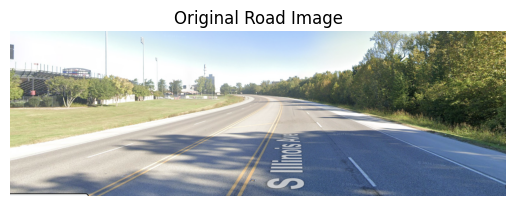

In [13]:
# PART A (Task 1) (Add more cells as necessary):
import cv2
import matplotlib.pyplot as plt

# Load the original image
original_image_path = '/kaggle/input/road-carbondale/Screenshot 2024-10-29 at 7.37.20PM.png'
original_image = cv2.imread(original_image_path)

# Preprocessing: Convert to grayscale (if needed)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Display original image
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Road Image')
plt.axis('off')
plt.show()


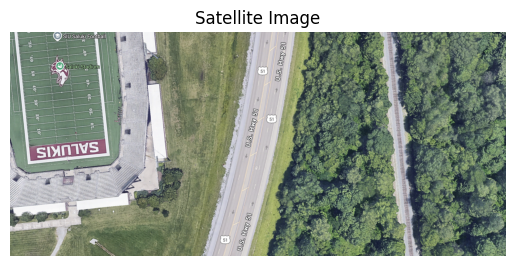

In [14]:
# Load the satellite image
satellite_image_path = '/kaggle/input/satelite/Screenshot 2024-10-29 at 7.40.49PM.png'
satellite_image = cv2.imread(satellite_image_path)

# Preprocessing: Convert to grayscale (if needed)
satellite_gray = cv2.cvtColor(satellite_image, cv2.COLOR_BGR2GRAY)

# Display satellite image
plt.imshow(cv2.cvtColor(satellite_image, cv2.COLOR_BGR2RGB))
plt.title('Satellite Image')
plt.axis('off')
plt.show()


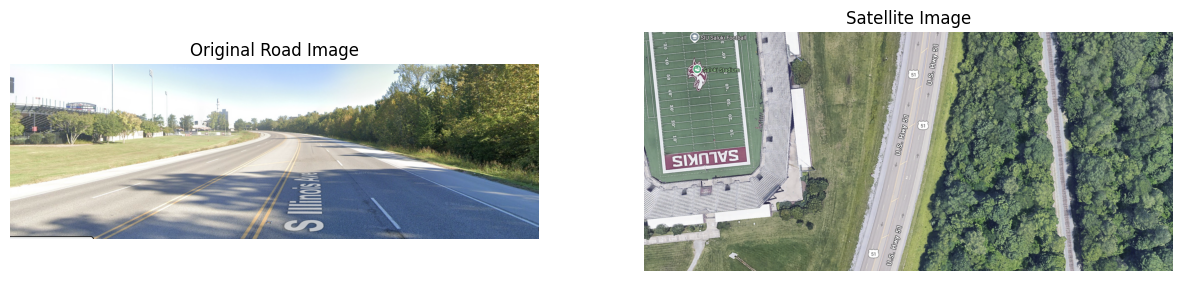

In [15]:
# Display both images side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Road Image')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(satellite_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Satellite Image')
axs[1].axis('off')

plt.show()


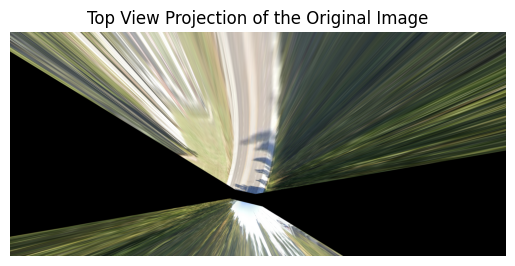

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 18.7 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-10-29 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 180MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


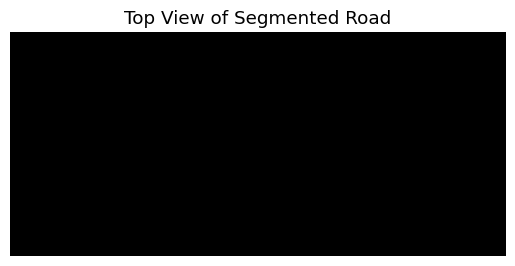

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load the original and satellite images
original_image_path = '/kaggle/input/road-carbondale/Screenshot 2024-10-29 at 7.37.20PM.png'
original_image = cv2.imread(original_image_path)

satellite_image_path = '/kaggle/input/satelite/Screenshot 2024-10-29 at 7.40.49PM.png'
satellite_image = cv2.imread(satellite_image_path)

# Define your points
original_points = np.array([[890, 477], [2021, 480], [1223, 404], [1714, 402]], dtype='float32')  # Original image points
satellite_points = np.array([[1195, 784], [1389, 822], [1217, 678], [1417, 697]], dtype='float32')  # Satellite image points

def compute_homography(original_points, satellite_points):
    A = []
    for i in range(len(original_points)):
        x, y = original_points[i][0], original_points[i][1]
        x_, y_ = satellite_points[i][0], satellite_points[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x * x_, y * x_, x_])
        A.append([0, 0, 0, -x, -y, -1, x * y_, y * y_, y_])
    A = np.array(A)
    
    # Perform SVD
    _, _, V = np.linalg.svd(A)
    h = V[-1]
    H = h.reshape(3, 3)
    
    return H

# Calculate the homography
H = compute_homography(original_points, satellite_points)

# Create a new image for the top view projection
top_view_image = cv2.warpPerspective(original_image, H, (satellite_image.shape[1], satellite_image.shape[0]))

# Display the top view projection
plt.imshow(cv2.cvtColor(top_view_image, cv2.COLOR_BGR2RGB))
plt.title('Top View Projection of the Original Image')
plt.axis('off')
plt.show()

# Load YOLOv5 model (make sure to install YOLOv5 in your environment)
# For Kaggle, use a pretrained model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Perform segmentation on the original image
results = model(original_image)

# Convert results to a segmented image
road_segmented_image = np.zeros_like(original_image)

# Loop through detected results
for *box, conf, cls in results.xyxy[0]:  # xyxy format
    # Get the class ID
    class_id = int(cls)
    
    # Filter for the 'car' class (adjust class id based on your model)
    if class_id == 2:  # Assuming 'car' is class ID 2
        x1, y1, x2, y2 = map(int, box)  # Convert to integers
        cv2.rectangle(road_segmented_image, (x1, y1), (x2, y2), (255, 255, 255), -1)  # Fill with white

# Display the segmented road
plt.imshow(cv2.cvtColor(road_segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Road')
plt.axis('off')
plt.show()

# Generate top view projection of the segmented road
top_view_segmented_road = cv2.warpPerspective(road_segmented_image, H, (satellite_image.shape[1], satellite_image.shape[0]))

# Display the top view projection of the segmented road
plt.imshow(cv2.cvtColor(top_view_segmented_road, cv2.COLOR_BGR2RGB))
plt.title('Top View of Segmented Road')
plt.axis('off')
plt.show()
